(ch2:finetune)=
# Fine-Tune your Model

Now that you have figured out an appropriate way to represent your network to learn from it, and you have learned how to train an algorithm to learn from it, it's time to tune things up a little bit. Let's start with the code we've gotten together so far:

In [100]:
import os
import urllib
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from graspologic.utils import import_edgelist, pass_to_ranks
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

# the AWS bucket the data is stored in
BUCKET_ROOT = "open-neurodata"
# the path to the data we are interested in
FMRI_PREFIX = "m2g/Functional/BNU1-11-12-20-m2g-func/Connectomes/Glasser_space-MNI152NLin6_res-2x2x2.nii.gz/"
FMRI_PATH = os.path.join("datasets", "fmri")  # the output folder
DS_KEY = "abs_edgelist"  # correlation matrices for the networks to exclude

def fetch_fmri_data(bucket=BUCKET_ROOT, fmri_prefix=FMRI_PREFIX,
                    output=FMRI_PATH, name=DS_KEY):
    """
    A function to fetch fMRI connectomes from AWS S3.
    """
    # check that output directory exists
    if not os.path.isdir(FMRI_PATH):
        os.makedirs(FMRI_PATH)
    # start boto3 session anonymously
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    # obtain the filenames
    bucket_conts = s3.list_objects(Bucket=bucket, 
                    Prefix=fmri_prefix)["Contents"]
    for s3_key in bucket_conts:
        # get the filename
        s3_object = s3_key['Key']
        # verify that we are grabbing the right file
        if name not in s3_object:
            op_fname = os.path.join(FMRI_PATH, str(s3_object.split('/')[-1]))
            if not os.path.exists(op_fname):
                s3.download_file(bucket, s3_object, op_fname)

def read_fmri_data(path=FMRI_PATH):
    """
    A function which loads the connectomes as adjacency matrices.
    """
    networks = [import_edgelist(os.path.join(path, fname)) for fname in os.listdir(path)]
    return np.stack(networks, axis=0)

def remove_isolates(A):
    """
    A function which removes isolated nodes from the 
    adjacency matrix A.
    """
    degree = A.sum(axis=0)  # sum along the rows to obtain the node degree
    out_degree = A.sum(axis=1)
    A_purged = A[~(degree == 0),:]
    A_purged = A_purged[:,~(degree == 0)]
    print("Purging {:d} nodes...".format((degree == 0).sum()))
    return A_purged

class CleanData(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X):
        return self

    def transform(self, X):
        print("Cleaning data...")
        Acleaned = remove_isolates(X)
        A_abs_cl = np.abs(Acleaned)
        self.A_ = A_abs_cl
        return self.A_
    
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        print("Scaling edge-weights...")
        A_scaled = pass_to_ranks(X)
        return (A_scaled)

num_pipeline = Pipeline([
    ('cleaner', CleanData()),
    ('scaler', FeatureScaler()),
])

In [105]:
import contextlib

fetch_fmri_data()

As_raw = read_fmri_data()
with contextlib.redirect_stdout(None):
    As = np.stack([num_pipeline.fit_transform(A) for A in As_raw], axis=0)

In the last section, you learned how you can take one of the networks, and use embeddings combined with various clustering techniques to learn about latent structure in your data.

However, there's a big caveat: your colleague sent you over a hundred networks, and you ignored all but one of them! Surely, there's something that you can learn from all of them, right?

Fortunately, when you have a multiple network problem, there are plenty of approaches that you can use to learn from all of them simultaneously. Let's break down how we can approach this now.

So, you know that you want to produce a representation of all of your networks. These networks all have the same nodes, which are the different areas of the brain. For all intents and purposes, you can assume that these different nodes mean the same thing across all of the different people, even if they are different based on each individual. What you want to learn is whether there is some *shared* structure across all of the different networks present in the nodes. To do this, you are going to want to be able to take *all* of your networks, and produce an embedding in which you can look at each *node* as its own object. Does anything exist to help you?

Sure does. As you will learn, a particular representation called [MASE](ch6:multinet:mase) does just this. It allows you to take many networks, and learn a single representation for the nodes across all of the networks. This representation, in particular, is going to effectively *borrow strength* from all of the networks you pass in, so you won't have to worry about whether you are just ignoring all of the networks but one like you did before. Let's see what MASE can do for us here:

In [106]:
from graspologic.embed import MultipleASE

embedding = MultipleASE().fit_transform(As)

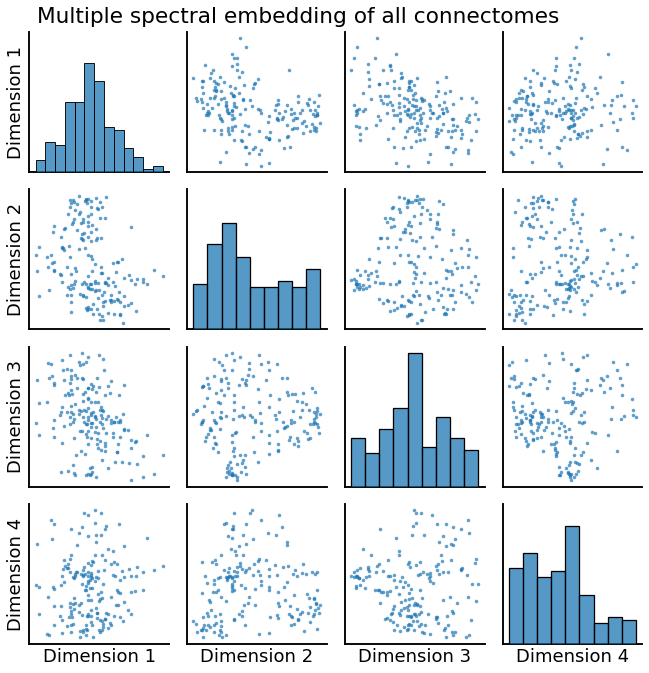

In [107]:
from graspologic.plot import pairplot

pairplot(embedding, title="Multiple spectral embedding of all connectomes");

Well, that looks pretty different! In particular, many of the plots look quite a bit more "blobby" than they did when we only looked at a single network. Let's take a look at what happens when we apply our clustering to this embedding instead:

In [ ]:
from graspologic.cluster import AutoGMMCluster

labels = AutoGMMCluster(max_components=10).fit_predict(embedding)

In [ ]:
pairplot(embedding, labels=labels,
         title="Multiple spectral embedding of all connectomes", 
         legend_name="Predicted Clusters");

So, what do these predicted clusters mean?

Let's see if we can find out!